C:\Users\AbdulSamad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
C:\Users\AbdulSamad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)


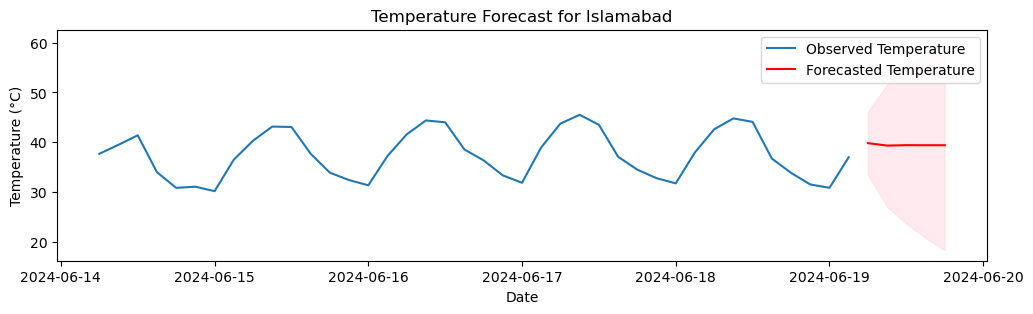

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import numpy as np
import tkinter as tk
from tkinter import messagebox, scrolledtext
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def speak(message):
    forecast_box.insert(tk.END, message + "\n")

def log_text(message):
    with open('weather_logg.txt', 'a') as f:
        f.write(message + '\n')

def get_current_weather(city):
    api_key = '13d6f372052b76fdc44bd6057ffb9dfc'
    base_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    response = requests.get(base_url)
    data = response.json()
    if data["cod"] != "404":
        weather_desc = data["weather"][0]["description"]
        temp = data["main"]["temp"]
        speak(f"The current temperature in {city} is {temp} degrees Celsius with {weather_desc}.")
        log_text(f"Current weather in {city}: {temp}°C, {weather_desc}")
    else:
        speak("City not found.")
        log_text("City not found.")

def fetch_weather_forecast(city):
    api_key = '13d6f372052b76fdc44bd6057ffb9dfc'
    base_url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={api_key}&units=metric"
    response = requests.get(base_url)
    data = response.json()
    if data["cod"] != "404":
        return data
    else:
        return None

def prepare_forecast_data(data):
    forecast_data = []
    for entry in data['list']:
        forecast_data.append({
            'ds': entry['dt_txt'],
            'y': entry['main']['temp']
        })
    df = pd.DataFrame(forecast_data)
    df['ds'] = pd.to_datetime(df['ds'])
    df.set_index('ds', inplace=True)
    return df

def adf_test(series):
    """Perform ADF test to check for stationarity"""
    result = adfuller(series, autolag='AIC')
    speak('ADF Statistic: {}'.format(result[0]))
    speak('p-value: {}'.format(result[1]))
    for key, value in result[4].items():
        speak('Critical Values:')
        speak('   {}: {}'.format(key, value))

def difference_series(series):
    return series.diff().dropna()

def fit_arima_model(series, order=(1,1,1)):
    model = SARIMAX(series, order=order)
    model_fit = model.fit(disp=False)
    return model_fit

def predict_future_weather(model, steps=16):
    forecast = model.get_forecast(steps=steps)
    return forecast.predicted_mean, forecast.conf_int()

def plot_forecast(df, forecast, conf_int, city):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(df.index, df, label='Observed Temperature')
    ax.plot(forecast.index, forecast, color='red', label='Forecasted Temperature')
    ax.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'Temperature Forecast for {city}')
    ax.legend()
    return fig

def get_weather_forecast(city, steps=5):
    data = fetch_weather_forecast(city)
    if data:
        df = prepare_forecast_data(data)
        forecast_box.insert(tk.END, f"Weather forecast for {city}:\n")
        adf_test(df['y']) 
        df_diff = difference_series(df['y']) 
        adf_test(df_diff) 
        model = fit_arima_model(df['y'])  
        forecast, conf_int = predict_future_weather(model, steps=steps)  
        fig = plot_forecast(df['y'], forecast, conf_int, city)

        for date, temp in forecast.items():
            forecast_box.insert(tk.END, f"{date.date()}: {temp:.2f} °C\n")
        
        for widget in graph_frame.winfo_children():
            widget.destroy()
        
        canvas = FigureCanvasTkAgg(fig, master=graph_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    else:
        speak("City not found.")
        log_text("City not found.")

def on_get_current_weather():
    city = city_entry.get()
    forecast_box.delete(1.0, tk.END)
    get_current_weather(city)

def on_get_weather_forecast():
    city = city_entry.get()
    forecast_box.delete(1.0, tk.END)
    get_weather_forecast(city, steps=5)

root = tk.Tk()
root.title("Weather Forecasting App")

tk.Label(root, text="Enter city name:").grid(row=0, column=0, padx=10, pady=10)
city_entry = tk.Entry(root)
city_entry.grid(row=0, column=1, padx=10, pady=10)

tk.Button(root, text="Get Current Weather", command=on_get_current_weather).grid(row=1, column=0, padx=10, pady=10)
tk.Button(root, text="Get Weather Forecast", command=on_get_weather_forecast).grid(row=1, column=1, padx=10, pady=10)

forecast_box = scrolledtext.ScrolledText(root, width=50, height=10)
forecast_box.grid(row=2, column=0, columnspan=2, padx=10, pady=10)

graph_frame = tk.Frame(root)
graph_frame.grid(row=3, column=0, columnspan=5, padx=15, pady=30, sticky="nsew")

graph_canvas = tk.Canvas(graph_frame)
graph_scrollbar = tk.Scrollbar(graph_frame, orient="vertical", command=graph_canvas.yview)
scrollable_frame = tk.Frame(graph_canvas)

scrollable_frame.bind(
    "<Configure>",
    lambda e: graph_canvas.configure(
        scrollregion=graph_canvas.bbox("all")
    )
)

graph_canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
graph_canvas.configure(yscrollcommand=graph_scrollbar.set)

graph_canvas.pack(side="left", fill="both", expand=True)
graph_scrollbar.pack(side="right", fill="y")

# Start the GUI event loop
root.mainloop()


In [4]:
pip install Flask


Note: you may need to restart the kernel to use updated packages.


In [5]:
from flask import Flask, url_for, request

app = Flask(__name__)

@app.route('/')
def index():
    server_address = request.url_root[:-1]  
    return f'Server Address: {server_address}'

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\AbdulSamad\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\AbdulSamad\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
